In [1]:
import pandas as pd
import altair as alt
import madmom
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from fastai.data.transforms import get_files
import snoop
from alive_progress import alive_it

%matplotlib inline

/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
files = get_files("../data/raw/train/", extensions=".wav")

onsets = [madmom.io.load_events(str(file)[:-3] + "onsets.gt") for file in files]
beats = [madmom.io.load_events(str(file)[:-3] + "beats.gt") for file in files]

i want to have a look, if I can somehow reduce the search space.
If I recall correctly, a histogramm and a clustering of the inter onset intervals might be a good starting point.

I think that using I diff operation with a step size from 1 to 4 might be enough. This relies on the asumption, that there are a maximum of 3 onsets between beats. I highly doubt that my approach will work.

In [25]:
def diff(array, step):
    return array - np.pad(array[:-step], (step, 0))

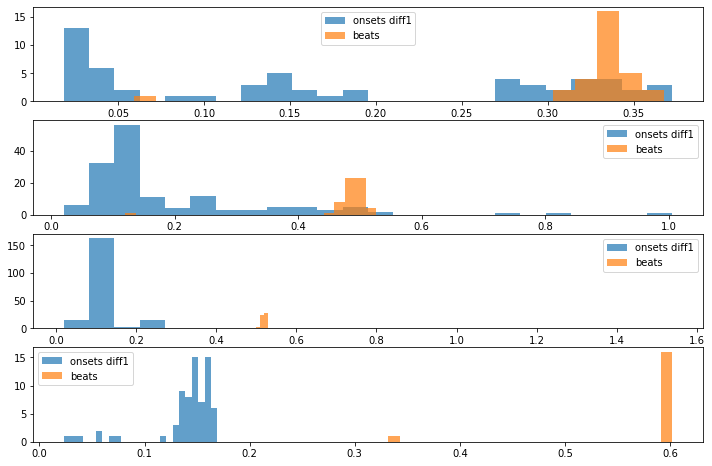

In [39]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=1)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    plt.hist(diff(onsets[song], 1), alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["onsets diff1", "beats"])

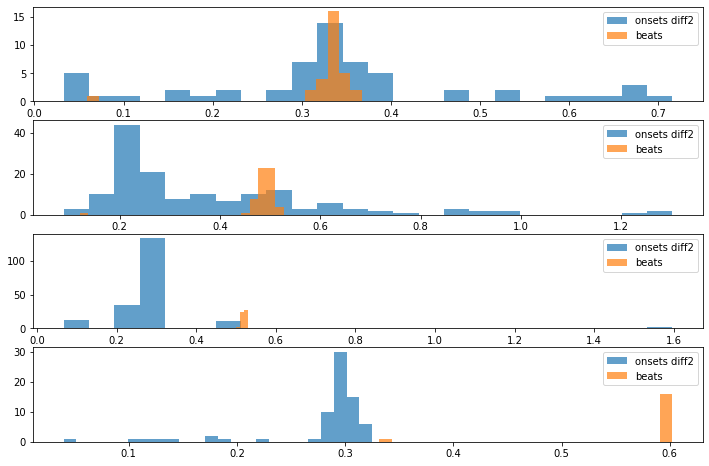

In [41]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=1)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    plt.hist(diff(onsets[song], 2), alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["onsets diff2", "beats"])

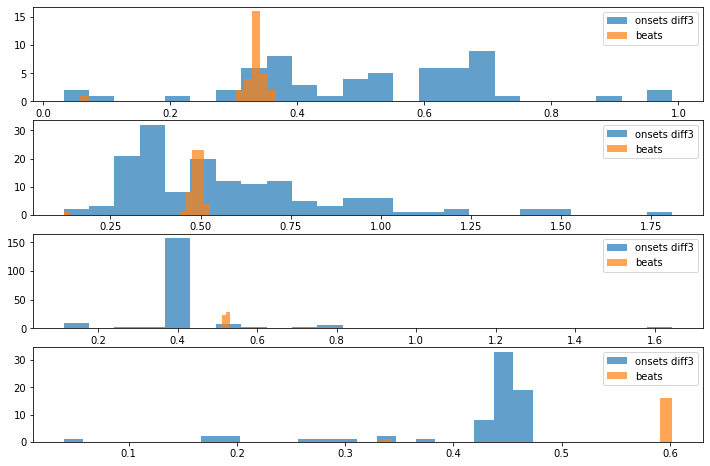

In [42]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=1)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    plt.hist(diff(onsets[song], 3), alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["onsets diff3", "beats"])

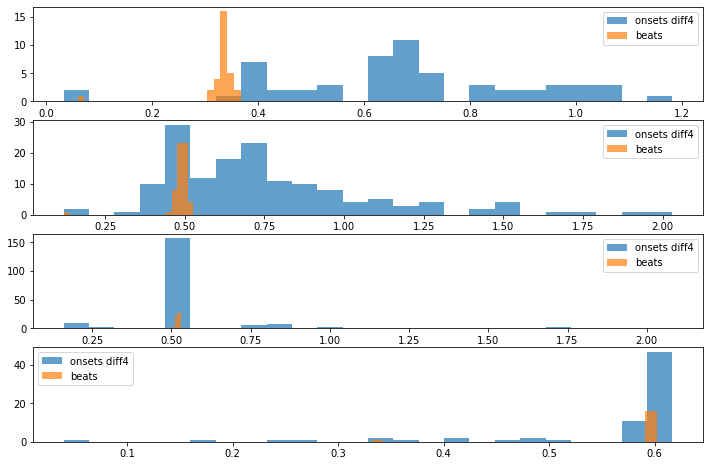

In [43]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=1)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    plt.hist(diff(onsets[song], 4), alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["onsets diff4", "beats"])

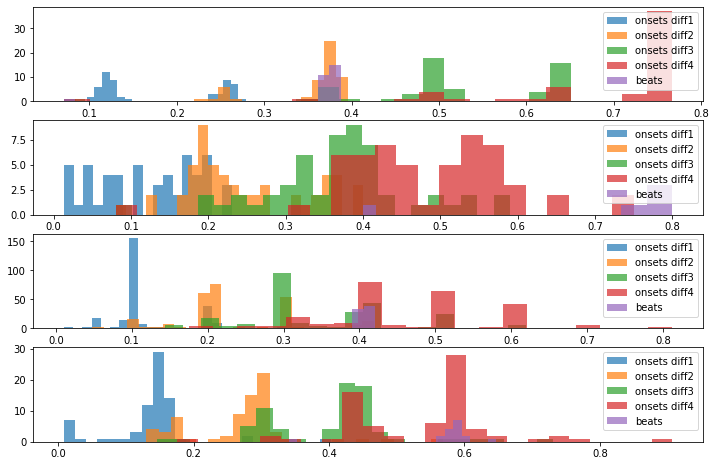

In [48]:
song = 16
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=1)")
for idx in range(4):
    plt.subplot(4, 1, idx + 1)
    plt.hist(diff(onsets[song + idx], 1), alpha=0.7, bins=24)
    plt.hist(diff(onsets[song + idx], 2), alpha=0.7, bins=24)
    plt.hist(diff(onsets[song + idx], 3), alpha=0.7, bins=24)
    plt.hist(diff(onsets[song + idx], 4), alpha=0.7, bins=24)
    plt.hist(diff(beats[song + idx], 1), alpha=0.7, bins=24)
    plt.legend(
        ["onsets diff1", "onsets diff2", "onsets diff3", "onsets diff4", "beats"]
    )

-> from looking at a few examples, I noticed, that using a diff with step size one almost never aligns with the beat diffs (this would correspond to only beats without offsets.

Therefore I am only considering diffs 2, 3 and 4

In [58]:
diffs = [diff(onsets[0], step) for step in range(2, 5, 1)]
diffs = np.concatenate(diffs)
diffs.shape

(174,)

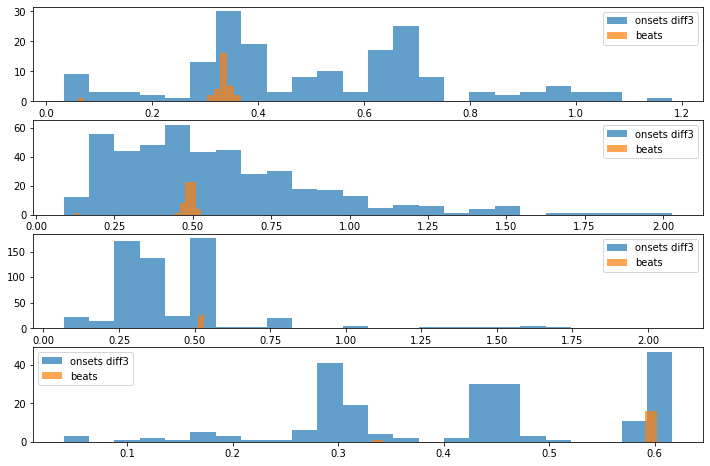

In [60]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=2-4)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    diffs = [diff(onsets[song], step) for step in range(2, 5, 1)]
    diffs = np.concatenate(diffs)
    diffs.shape
    plt.hist(diffs, alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["onsets diff3", "beats"])

In [63]:
from scipy.cluster.vq import kmeans

In [68]:
diffs = [diff(onsets[0], step) for step in range(2, 5, 1)]
diffs = np.concatenate(diffs)

centroids, _ = kmeans(diffs, 3)

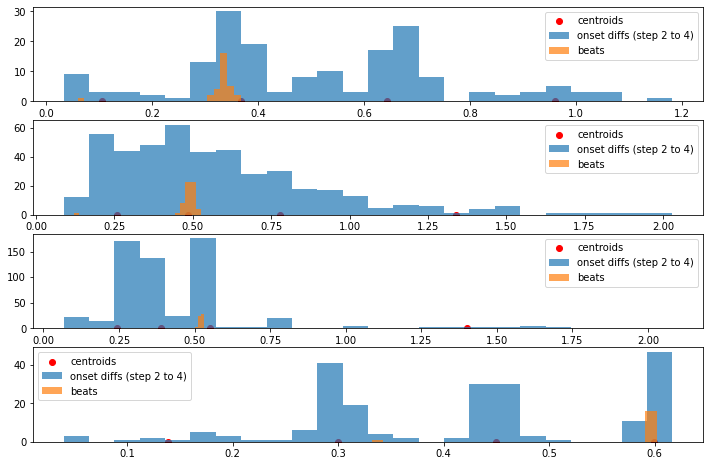

In [75]:
plt.figure(figsize=(12, 8))
plt.title("histogram of onsets and beats difference (step=2-4)")
for song in range(4):
    plt.subplot(4, 1, song + 1)
    diffs = [diff(onsets[song], step) for step in range(2, 5, 1)]
    diffs = np.concatenate(diffs)
    diffs.shape
    centroids, _ = kmeans(diffs, 4)
    plt.scatter(centroids, np.zeros_like(centroids), color="red")
    plt.hist(diffs, alpha=0.7, bins=24)
    plt.hist(diff(beats[song], 1), alpha=0.7, bins=24)
    plt.legend(["centroids", "onset diffs (step 2 to 4)", "beats"])

-> kmeans with 4 centroids seems like a good fit for our use-case

with this approach, I can now narrow down the search space.

Things that additionally might improve performance are:

+ taking the gaussian peaks instead of the onsets
+ reducing the score if peaks are missed
+ adapting the width of the gaussians based on the bpm value
+ when the best bpm value is found, interpolate the bpm values